# Integrated gradients for Mnist

In this notebook we apply the integrated gradients method to a convolutional network trained on the mnist dataset. 
Integrated gradients defines an attribution value for each feature by considering the integral of the model's  gradients with respect to the input taken along a straight path from a baseline $x^\prime$ to the input $x.$

A more detailed description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in Sundararajan et al., ["Axiomatic Attribution for Deep Networks"](https://arxiv.org/abs/1703.01365).

In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
from alibi.utils.visualization import plot_attributions, visualize_image_attr
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.0
Eager execution enabled:  True


## Load data

Loading and preparing the mnist data set.

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Training a convolutional neural network on the mnist dataset. The model include 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [5]:
load_mnist_model = True
save_model = False

In [6]:
filepath = './model_mnist/'  # change to directory where model is downloaded
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Calculate integrated gradients

The IntegratedGradients class implements the integrated gradients attribution method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb).

In the following example, the baselines (i. e. the starting points of the gradients' integral) are black images (all pixel's values are set to zero). This means that black areas of the image will always have zero attributions.
The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [7]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

In [8]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_red = X_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]
explanation = ig.explain(X_test_red, 
                         baselines=None, 
                         target=test_labels_red,
                         return_convergence_delta=return_convergence_delta, 
                         return_predictions=return_predictions)

In [9]:
# Get attributions values from the explanation object
attrs = explanation.data['attributions']

## Visualize attributions

Sample images from the test dataset and their attributions.

* The first column shows the original image. 
* The second column shows the raw values of the attributions clipped in the $[-1, 1]$ range.
* The third columns shows the positive valued attributions clipped in the $[0, 1]$ range.
* The fourth columns shows the negative valued attributions clipped in the $[-1, 0]$ range.

The attributions are calculated using the black image as a baseline for all samples.

In [10]:
label_idx_to_class_names = {l:l for l in test_labels}

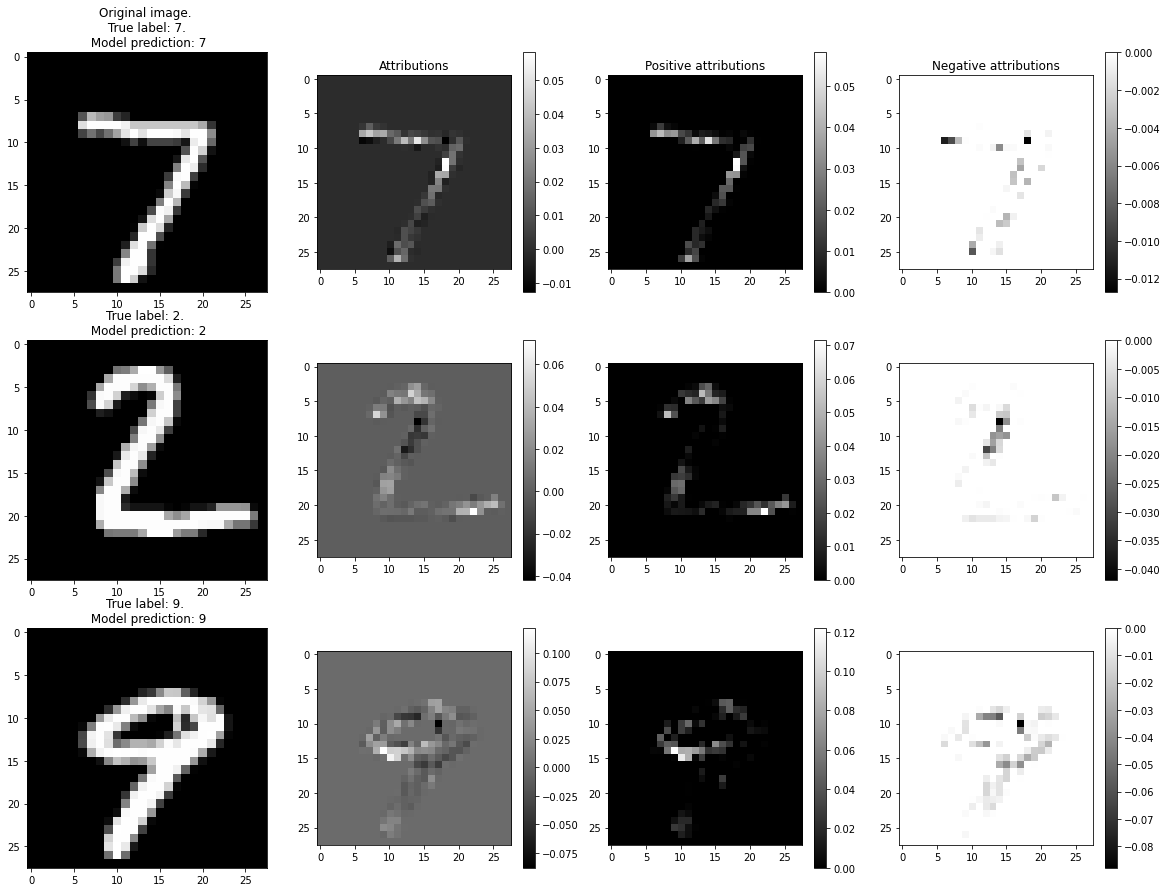

In [11]:
plot_attributions(model, X_test, test_labels, attrs, label_idx_to_class_names, 
                  figsize=(20, 15), scale_attrs=False, cmap='gray')